In [1]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib
from collections import OrderedDict
import itertools
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

In [2]:
%store -r da_dv
%store -r da_bv
%store -r da_sw
%store -r da_dcs


da_dv = da_dv.load()

## Raw Delta V 

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


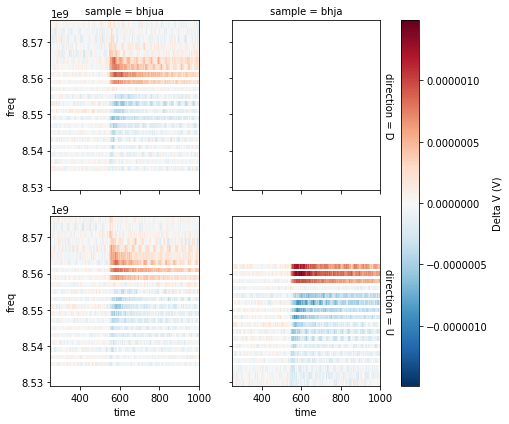

In [3]:
da_dv.name = 'Delta V (V)'

col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
g = da_dv.dropna('fluence','all').mean('fluence').sel(time = slice(250e-9,1000e-9)).plot(x = 'time', y = 'freq', row = 'direction', col = col)
# g.fig.autofmt_xdate()

for axs in g.axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

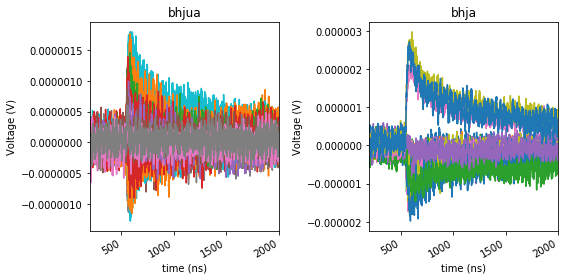

In [4]:
size = len(da_dv.indexes['sample'])
fig, axes = plt.subplots(1,size, figsize = (4*size, 2*size), squeeze=False)

for i,samp in enumerate(da_dv.indexes['sample']):
    data = da_dv.sel(sample = samp).sel(direction = 'U').dropna('fluence','all').isel(fluence = -1).dropna('time','all')
    ax = axes[0][i]
    f0 = 8.542e9
    freqs = data.indexes['freq']
    for freq in freqs:
        trace = data.sel(freq = freq).dropna('time','all')
        ax.plot(trace.to_series())
#     ax = plot.redbluetransient(ax,data, f0)
    ax.set_title(samp)
    ax.set_xlim([200e-9,2000e-9])
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('Voltage (V)')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

# ax.legend()
fig.autofmt_xdate()
fig.tight_layout()

## Normalized Delta V 

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


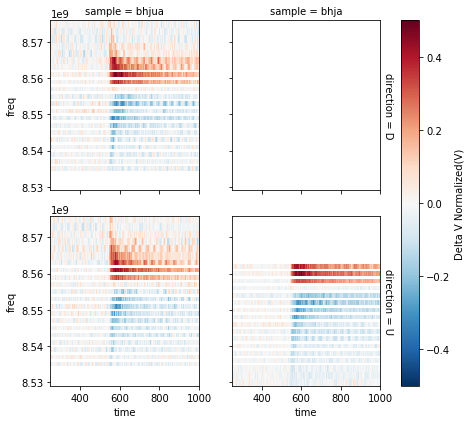

In [5]:
def norm(x):
    return x/x.max()

da_dv_norm = da_dv.groupby('sample').apply(norm)

da_dv_norm.name = 'Delta V Normalized(V)'

col = None if (len(da_dv_norm.indexes['sample']) == 1)  else 'sample'
g = da_dv_norm.dropna('fluence','all').mean('fluence').sel(time = slice(250e-9,1000e-9)).plot(x = 'time', y = 'freq', row = 'direction', col = col)
# g.fig.autofmt_xdate()

for axs in g.axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

## plot the dark cavity sweeps

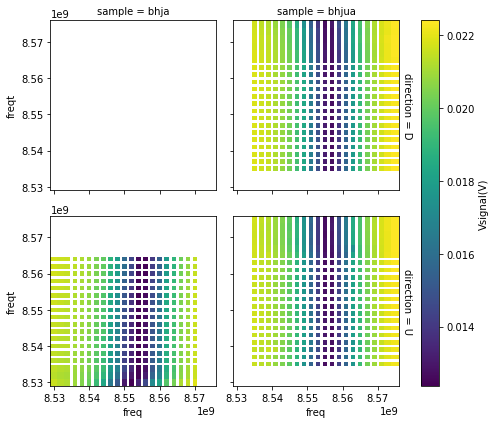

In [6]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
da_dcs.plot(x = 'freq',y='freqt',row = 'direction',col = col)

bhja
bhjua


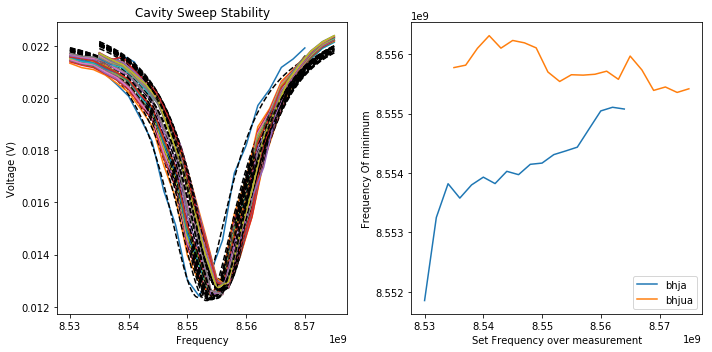

In [7]:
p_labels = ['f0','w','R','Rinf'] 
epsilon = 0.00001
bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
window = 100

fig, axes = plt.subplots(1,2, figsize = (10,5))

daf0s = []
for samp in da_dcs.indexes['sample']:
    print(samp)
    da = da_dcs.sel(sample = samp).sel(direction = 'U').dropna('freq','all').dropna('freqt','all')
    f0s = []
    for freqt in da.indexes['freqt']:
        d = da.sel(freqt = freqt)
        axes[0].plot(d.to_series())

        Rinf = 0.02125
        f0 = d.to_series().idxmin()
        p0 =[f0,0.01,Rinf,1e7 ]

        v0_fit, v0_p,v0_sl = analysis.fitsweep(d, p0, bounds, window , 'lor',p_labels)
        popt = v0_p[0]
        f0s.append(popt[0])

        freqs = da.indexes['freq']
        freqs_i = np.linspace(freqs.min(),freqs.max(),100)
        dfit = v0_fit(freqs_i)
        dfit = pd.Series(dfit, index = freqs_i)
        axes[0].plot(dfit, color = 'black', linestyle = '--')
    
    daf0s.append(xr.DataArray(f0s, coords = {'freqt' : da.indexes['freqt']}, dims= ['freqt']).assign_coords(sample = samp).expand_dims('sample'))


daf0s = xr.concat(daf0s, dim = 'freqt')

for samp in daf0s.indexes['sample']:
    axes[1].plot(daf0s.sel(sample = samp).to_series(), label = samp)

axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Voltage (V)')

axes[1].legend()
axes[1].set_ylabel('Frequency Of minimum')
axes[1].set_xlabel('Set Frequency over measurement')
axes[0].set_title('Cavity Sweep Stability')
fig.tight_layout()

## Interpolate the dark cavity sweep to match with the delta v data array

In [8]:
da_dcsi = da_dcs.interp_like(da_dv,method = 'nearest')

For now just pull out one freqt

In [9]:
# For partial data sets, cut down the dark cavity sweep, not sure if this is nessecary
# fmin = da_dv.indexes['freq'].min()
# fmax = da_dv.indexes['freq'].max()
# idxmin = abs(da_dcs.indexes['freq'] - fmin).argmin()
# idxmax = abs(da_dcs.indexes['freq'] - fmax).argmin() + 1 #???

idx = 5
das = []
for samp in da_dcsi.indexes['sample']:
    freqt = da_dcsi.sel(sample = samp).dropna('freqt','all').indexes['freqt'][idx]
    das.append(da_dcsi.sel(sample = samp).sel(freqt = freqt).drop('freqt').dropna('freq','all'))
    
v0s = xr.concat(das, dim = 'sample')

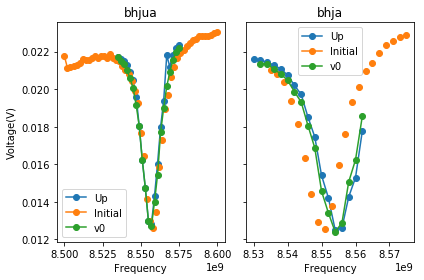

In [10]:
samples = da_bv.indexes['sample']
size = len(samples)
fig, axes = plt.subplots(1,size, figsize = (3*size,2*size) , sharey = True, squeeze=False)

for i, samp in enumerate(samples):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna('freq','all')
    axes[0][i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
    swp_init = da_sw.sel(sample = samp, tc = '_1_', swtime = 0)
    axes[0][i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    v0= v0s.sel(sample = samp,direction = 'U').dropna('freq','all')
    axes[0][i].plot(v0.to_series(),marker = 'o',label = 'v0')
    axes[0][i].set_title(samp)
    axes[0][i].legend()
    axes[0][i].set_xlabel('Frequency')
    axes[0][0].set_ylabel('Voltage(V)') 

    fig.tight_layout()

## fitting setup

Define fit parameters

In [15]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    f0 = None
    p0 =[f0,0.01,Rinf,1e7]
    p_labels = ['f0','R0','Rinf','w'] 
    epsilon = 0.001
#     bounds = ([0,0,Rinf - epsilon,0 ],[np.inf,np.inf,0, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100
    samps = v0s.indexes['sample']
    Ks = pd.Series(index = samps) #Define only for lorentzian as poly fits need Ks

# TODO: need to pass out all covariance only happening for one lor fn
    
elif fittype == 'poly':
    window = 2
    p_labels = [ 'f0','R0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]
    

time1 = 500e-9
time2 = 800e-9
timerange = slice(time1,time2)
timestep = 10e-9 #not index and has been moved inside for loop...need to check

direcs = ['U']
samps = v0s.indexes['sample']
# samps = ['bia','bid']
flus = slice(-1,0,-1)
seldicts = list(analysis.dict_product({'sample' :samps, 'direction':direcs}))


Initialize data and perform fits

In [16]:
###Setup dictionaries to input paramters into
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_dcs.isel(freqt = 0).drop('freqt').isel(freq = 0).drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)

ds_p_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0
ds_cov_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0


###Generate Vshift data array
dvs = da_dv.sel(time = timerange)
vss = v0s + dvs

###Create data arrays to put fits into
fits_v0 = v0s.copy(deep= True).where(False)
fits = dvs.copy(deep = True).where(False)

#numer of fits for percent indicator, not working. 
num = len(seldicts)*(abs(flus.stop - flus.start))
### FITTING

for seldict in seldicts:
    clear_output(wait = True)
    
    ### V0 fitting
    v0 = v0s.sel(seldict).dropna('freq','all')
    samp = seldict['sample']
    direc = seldict['direction']
    if fittype == 'lor':
        ##Set minimum frequency to minimum of data
        p0[0] = None    
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    popt = v0_p[0]
    freqs = v0.indexes['freq'][v0_sl]
    fits_v0.loc[samp,direc,freqs] = v0_fit(freqs)

    for j, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp,direc] = popt[j]
    
    if fittype == 'lor':
        Ks[samp] = analysis.calc_K(f0 = popt[0], R0_norm = popt[1]/popt[2],w = popt[3], printparams = False)
    elif fittype =='poly':
        print('poly fit, using old K value (do lorentzian fit first)')
    print('K sample ' + samp + ' = ' + str(Ks.loc[samp]))
    
    ###Time Series fitting
    
    vs1 = vss.sel(seldict).dropna('fluence','all').dropna('freq','all').dropna('time','all')
    
    times = vs1.indexes['time']
    timeidx1 = pd.Series(abs(times-time1)).idxmin()
    timeidx2 = pd.Series(abs(times-time2)).idxmin()
    dt = times[1] - times[0]
    idxstep = int(timestep/dt)
    
    fittimes = times[slice(timeidx1,timeidx2,idxstep)]
#     print('fitting for time idxs ' + str(fittimes) )
    
    i=0
    numflus = len(vs1.indexes['fluence'][flus.start:flus.stop:flus.step])
    for flu in vs1.indexes['fluence'][flus]:
        vs2 = vs1.sel(fluence = flu)
        
        print(str((i/numflus)*100.0) + ' %') 
        i=i+1
        for time in fittimes:
            vs3 = vs2.dropna('freq','all').sel(time = time)
            if fittype == 'lor':
                ##Set minimum frequency to minimum of data
                p0[0] = None
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)
            popt = vs_p[0]
            pcov = vs_p[1]
            perr = np.sqrt(np.diag(pcov))

            freqs = vs3.indexes['freq'][vs_sl]
            fits.loc[samp,direc,freqs,flu,time] = vs_fit(freqs).values   # Note that freqs is also in the index, only updating the freqeuncies that correspond to that sample
            
            #Fill paramter data sets
            
            if fittype == 'lor':
                ds_p_r['f0'].loc[samp,direc,flu,time] = popt[0]
                ds_p_r['R0'].loc[samp,direc,flu,time] = popt[1]
                ds_p_r['Rinf'].loc[samp,direc,flu,time] = popt[2]
                ds_p_r['w'].loc[samp,direc,flu,time] = popt[3]

                ds_cov_r['f0'].loc[samp,direc,flu,time] = perr[0]
                ds_cov_r['R0'].loc[samp,direc,flu,time] = perr[1]
                ds_cov_r['Rinf'].loc[samp,direc,flu,time] = perr[2]
                ds_cov_r['w'].loc[samp,direc,flu,time] = perr[3]
            elif fittype == 'poly':
                ds_p_r['f0'].loc[samp,direc,flu,time] = popt[1]
                ds_p_r['R0'].loc[samp,direc,flu,time] = popt[0]
                
                ds_cov_r['f0'].loc[samp,direc,flu,time] = perr[1]
                ds_cov_r['R0'].loc[samp,direc,flu,time] = perr[0]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)
print('done')

<xarray.DataArray 'Vsignal(V)' (freq: 16)>
array([0.021362, 0.021354, 0.021063, 0.020811, 0.02047 , 0.01987 , 0.019311,
       0.018061, 0.016874, 0.014564, 0.013415, 0.012398, 0.012874, 0.015063,
       0.016236, 0.018559])
Coordinates:
  * freq       (freq) float64 8.532e+09 8.534e+09 ... 8.56e+09 8.562e+09
    direction  <U1 'U'
    sample     <U5 'bhja'
K sample bhja = 72328.06872385567
0.0 %
done


# Visualizing Fit results 

In [18]:
%matplotlib ipympl

samp = 'bhja'

### Pull out arrays for one sample and get rid of nas
dst = ds.sel(sample = samp).sel(direction = 'U').drop('direction')#.sel(time = times) #try drop any fluence nan...

fits_samp = dst['fits'].dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
fittimes = fits_samp.indexes['time']
#cut down dvs and fits to only fit times. 
dvs_samp = dst['dvs'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
vss_samp = dst['vss'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
dst_samp = xr.merge([dvs_samp,fits_samp,vss_samp])


### Setup initial plot with items at time =0 eventually should be removed
v0 = v0s.sel(sample = samp).sel(direction = 'U').drop('direction').dropna('freq','all')
fit_v0 = fits_v0.loc[samp].sel(direction = 'U').drop('direction').dropna('freq','all')
dv = dst_samp['dvs'].isel(time = 0 )
fit = dst_samp['fits'].isel(time = 0 )
vs = dst_samp['vss'].isel(time = 0 )

# human readable time array for slider
hrtimes = fittimes.values*1e9
hrtimetup = (hrtimes[0],hrtimes[-1],hrtimes[1]-hrtimes[0])

fig, axes, lns = plot.vsplotxr(dv, vs = vs, fit = fit, v0 = v0, fit_v0 = fit_v0, plotkwargs={'figsize' : (10,8)})

axes[0].set_ylim([dvs_samp.min(),dvs_samp.max()])

interact(plot.inter_vsplot, timesel=hrtimetup   ,dst_samp = fixed(dst_samp),lns = fixed(lns), fig = fixed(fig));

FigureCanvasNbAgg()

interactive(children=(FloatSlider(value=646.9999999999993, description='timesel', max=794.0, min=500.0, step=9…

In [ ]:
#plot.sweepfitanim(dst, interval = 100)   # Not currently working

## Fit error 

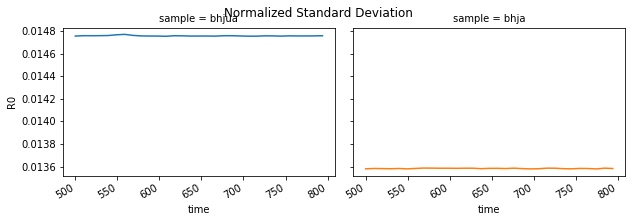

In [19]:
%matplotlib inline

g = (ds_cov_r['R0']/ds_p_r['R0']).sel(direction = 'U').dropna('fluence','all').plot(hue = 'fluence', col = 'sample')

for ax in g.axes[0]:
#     ax.set_yscale('log')
#     ax.set_ylim([-1,2])
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    
    lns = ax.lines
    for ln in lns:
        plot.dropna_ln(ln)
        
g.fig.suptitle('Normalized Standard Deviation')
g.fig.tight_layout()
g.fig.autofmt_xdate()
g.fig.legends[0].remove()

## Calculating the complex conductance 


In [20]:
e0 = 8.854e-12
F=1

def R02cond(R0t):
    samp = R0t.coords['sample'].values.item()
    K = Ks[samp]
    R0t0 = R0t.dropna('time','all').isel(time = 0)
    cond = ((R0t-R0t0)/R0t0)/K
    return cond

In [21]:
ft = ds_p_r['f0']#.sel(direction =direc)
f0 = ft.isel(time = 0)
sigi = -1*(ft-f0)*e0/F
sigiu = -1*(ds_cov_r['f0'])*e0/F

# Calculate conductance from FWHM
# wt = ds_p_r['w'].sel(direction =direc)
# w0 = wt.isel(time = 0)
# deltaFWHM = wt - w0
# sigr = deltaFWHM*e0/(2*F)

# Calculate real conductance from deltaR/R   
sigr = ds_p_r['R0'].groupby('sample').apply(R02cond)

sigr.name = '$\Delta G_r $ (S)'
sigi.name = '$\Delta G_i $ (S)'

## Downselect data 

In [64]:
# fluencesel = slice(0,-1)
fluencesel = -1
direc = 'U'

def fluencered(da):
    da_s = da.sel(direction =direc).dropna('fluence','all').isel(fluence = fluencesel).dropna('time','all')
    return da_s

sigr_s = sigr.groupby('sample').apply(fluencered)
sigi_s = sigi.groupby('sample').apply(fluencered)

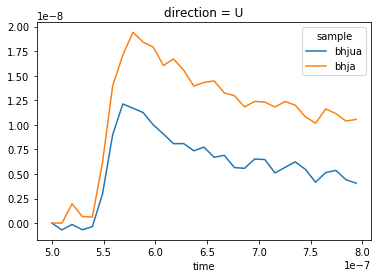

In [66]:
g = sigi_s.plot( hue = 'sample',x = 'time')
# plt.yscale('log')
# g.fig.legends[0].remove()


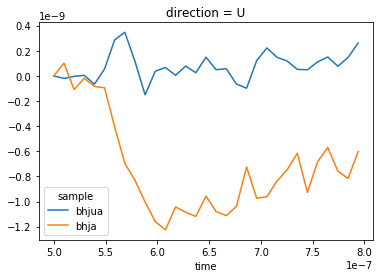

In [81]:
g = sigr_s.plot( hue = 'sample',x = 'time')
# plt.yscale('log')
# g.fig.legends[0].remove()


## Calculate real/imaginary ratio

(-0.3, 0.3)

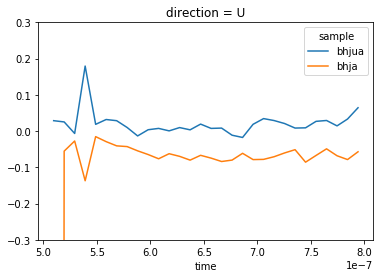

In [69]:


# ratio = (sigr_s/sigi_s).mean('fluence')
# g = ratio.plot(x='time',hue = 'sample', row = 'direction')

ratio = (sigr_s/sigi_s)
g = ratio.plot(x='time',hue = 'sample')
g
plt.ylim([-0.3,0.3])

# for ax in g.axes.flatten():
#     ax.set_ylim([-0.3,0.3])
#     ax.set_ylabel('Ratio (real/Imaginary)')
#     lns = ax.lines
#     for ln in lns:
#         plot.dropna_ln(ln)
#         mean = ln.get_ydata().mean()
#         if mean == mean:
#             string = ax.title.get_text() + '\n   mean: ' + '{0:.3f}'.format(mean)
#             ax.set_title(string)

# Calculating (complex) figure of merit 

In [73]:
beta = 2.25
M = 0.25
FA = 1
e = 1.6e-19

def fom(x):
    fluence = x.coords['fluence'].values
    return x/(beta*e*fluence*FA*M)

fom_r = sigr_s.groupby('fluence').apply(fom)
fom_i = sigi_s.groupby('fluence').apply(fom)

fom_r.name = '$\phi\Sigma\mu_R \ (cm^2/Vs)$'
fom_i.name = '$\phi\Sigma\mu_I \ (cm^2/Vs)$'

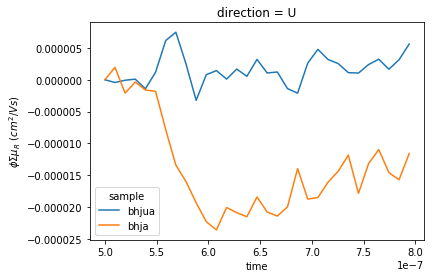

In [77]:
g = fom_r.plot(x = 'time',hue = 'sample' )

# for ax in g.axes.flatten():
# #     ax.set_yscale('log')
#     ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
# #     ax.set_ylim([1e-3,1e0])
#     lns = ax.lines
#     for ln in lns:
#         plot.dropna_ln(ln)
        
# g.fig.legends[0].remove()
# g.fig.suptitle('Real FOM')
# g.fig.tight_layout()

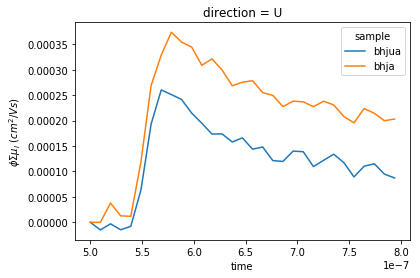

In [79]:
g = fom_i.plot(x = 'time',hue = 'sample')

# for ax in g.axes.flatten():
#     ax.set_yscale('log')
#     ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
# #     ax.set_ylim([1e-3,1e1])
#     lns = ax.lines
#     for ln in lns:
#         plot.dropna_ln(ln)
        
# # g.fig.legends[0].remove()
# g.fig.suptitle('Imaginary FOM')
# g.fig.tight_layout()

### Uncertianty calculation 

In [25]:
import uncertainties.unumpy as unp

R0u = unp.uarray(ds_p_r['R0'].values,ds_cov_r['R0'].values)
daR0u = xr.DataArray(R0u, coords = ds_p_r['R0'].coords, dims = ds_p_r['R0'].dims)
sigruarr= daR0u.groupby('sample').apply(R02cond)
    
sigr = unp.nominal_values(sigruarr.values)
sigru = unp.std_devs(sigruarr.values)
sigr = xr.DataArray(sigr, coords = ds_p_r['R0'].coords, dims = ds_p_r['R0'].dims)
sigru = xr.DataArray(sigru, coords = ds_p_r['R0'].coords, dims = ds_p_r['R0'].dims)

f0u = unp.uarray(ds_p_r['f0'].values,ds_cov_r['f0'].values)

daf0u = xr.DataArray(f0u, coords = ds_p_r['f0'].coords, dims = ds_p_r['f0'].dims)
f0t0 = daf0u.isel(time = 0)
sigiuarr = -1*(daf0u-f0t0)*e0/F
    
sigi = unp.nominal_values(sigiuarr.values)
sigiu = unp.std_devs(sigiuarr.values)
sigi = xr.DataArray(sigi, coords = ds_p_r['f0'].coords, dims = ds_p_r['f0'].dims)
sigiu = xr.DataArray(sigiu, coords = ds_p_r['f0'].coords, dims = ds_p_r['f0'].dims)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


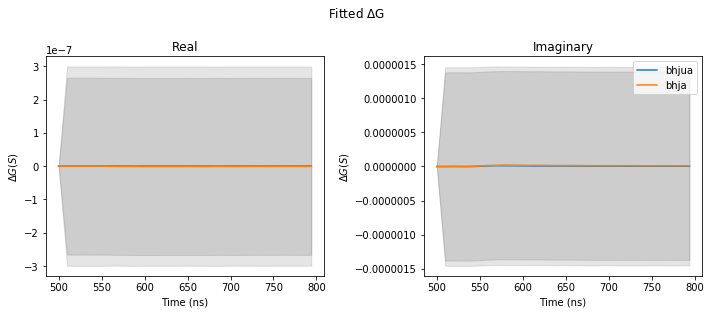

In [26]:
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = False)
fluencesel = -1
uc = True

for sample in sigi.indexes['sample']:
    s = sigi.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
    axes[1].xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    axes[1].set_xlabel('Time (ns)')
    axes[1].plot(s, label = sample)
    axes[1].set_title('Imaginary')
    axes[1].set_ylabel('$\Delta G (S)$')

    if uc:
        su = sigiu.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
        axes[1].fill_between(s.index, (s-su).values, (s+su).values, alpha = 0.1, color = 'black')
    
    s = sigr.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
    axes[0].xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    axes[0].set_xlabel('Time (ns)')
    axes[0].plot(s, label = sample)
    axes[0].set_title('Real')
    axes[0].set_ylabel('$\Delta G (S)$')
    if uc:
        su = sigru.sel(sample = sample).dropna('fluence','all').isel(fluence = fluencesel).sel(direction = 'U').dropna('time','all').to_series()
        axes[0].fill_between(s.index, (s-su).values, (s+su).values, alpha = 0.1, color = 'black')

plt.legend()
fig.suptitle('Fitted $\Delta$G', y = 1.08)
fig.tight_layout()